<a href="https://colab.research.google.com/github/tuntul17/FIZ425E/blob/main/NBA_data.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
#operation sys.
import os,shutil
#as ususal
import pandas as pd
import numpy as np
#to scrape
import requests as rq
import time #Just curious how will it take
#plot
from pylab import *
import plotly #this is new package for me
import plotly.express as px
import plotly.graph_objects as go 
import seaborn as sns #this is also new
#ML
import torch

import sklearn as sk
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier

import time

# Web scrapping:

In [ ]:
#before all the web scraping, I want to create a base df!
url = "https://stats.nba.com/stats/leagueLeaders?LeagueID=00&PerMode=Totals&Scope=Rookies&Season=2020-21&SeasonType=Playoffs&StatCategory=PTS"
R = rq.get(url).json()
headers = R["resultSet"]["headers"]

In [ ]:
player = ["S","Rookies"]
year = np.arange(2000,2022)
season_type = ["Playoffs","Regular%20Season"]
df = pd.DataFrame(columns=headers)
T = time.time()
for y in year:
  for s in season_type:
    for p in player:
      if y-2000<10:
        url = f"https://stats.nba.com/stats/leagueLeaders?LeagueID=00&PerMode=Totals&Scope={p}&Season={str(y)}-0{str(y-1999)}&SeasonType={s}&StatCategory=PTS"
      if y-2000>=10:
        url = f"https://stats.nba.com/stats/leagueLeaders?LeagueID=00&PerMode=Totals&Scope={p}&Season={str(y)}-{str(y-1999)}&SeasonType={s}&StatCategory=PTS"
      R = rq.get(url).json()
      #df = pd.DataFrame(R["resultSet"]['rowSet'],columns = headers)
      temp_df1 = pd.DataFrame(R["resultSet"]["rowSet"],columns= headers)
      temp_df2 = pd.DataFrame({'Year':[int(y) for i in range(len(temp_df1))],
                      "Rookie":[p for i in range(len(temp_df1))],
                      'Season_type':[s for i in range(len(temp_df1))]})
      temp3 = pd.concat([temp_df2,temp_df1],axis=1)
      df = pd.concat([temp3,df],axis=0)
      
df['Season_type'].replace("Regular%20Season","Regular Season",inplace=True)
df["Rookie"].replace("S","Non-Rookie",inplace=True)
df["Rookie"].replace("Rookies","Rookie",inplace=True)
print(f"web scraping took {round(time.time()-T,2)} second ")
T1 = time.time()
df.to_excel("RAW_20_NBA.xlsx",index=False)
print(f"saving as a xlsx file took {round(time.time()-T1,2)} second")

web scraping took 43.23 second 
saving as a xlsx file took 13.69 second


* **This is raw data**
* Move this file to drive just in case!

In [ ]:
shutil.copy("/content/RAW_20_NBA.xlsx","/content/drive/MyDrive/Colab Notebooks")

'/content/drive/MyDrive/Colab Notebooks/RAW_20_NBA.xlsx'

# Data Cleaning:

In [36]:
rawData = pd.read_excel("/content/drive/MyDrive/Colab Notebooks/RAW_20_NBA.xlsx")
#rawData = pd.read_excel("/content/RAW_20_NBA.xlsx")

In [37]:
#rawData.sample(5)
rawData.sample(5)

,Year,Rookie,Season_type,PLAYER_ID,RANK,PLAYER,TEAM_ID,TEAM,GP,MIN,...,REB,AST,STL,BLK,TOV,PF,PTS,EFF,AST_TOV,STL_TOV
6077,2014,Rookie,Regular Season,203953,21,Jabari Parker,1610612749,MIL,25,738,...,138,42,31,5,47,42,308,323,0.89,0.66
7465,2013,Non-Rookie,Playoffs,2216,60,Zach Randolph,1610612763,MEM,6,234,...,52,14,5,1,10,13,109,93,1.40,0.50
2290,2019,Non-Rookie,Regular Season,1628408,354,PJ Dozier,1610612743,DEN,29,412,...,55,63,14,6,27,45,168,179,2.33,0.52
388,2021,Non-Rookie,Regular Season,204060,299,Joe Ingles,1610612757,POR,45,1122,...,131,158,23,5,46,82,325,421,3.44,0.50
13597,2003,Rookie,Regular Season,2552,33,Michael Sweetney,1610612752,NYK,42,495,...,157,14,18,12,32,57,180,262,0.44,0.56


In [38]:
rawData.drop(columns=["RANK","TEAM_ID","PLAYER_ID"],inplace=True)
rawData.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16398 entries, 0 to 16397
Data columns (total 28 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   Year         16398 non-null  int64  
 1   Rookie       16398 non-null  object 
 2   Season_type  16398 non-null  object 
 3   PLAYER       16398 non-null  object 
 4   TEAM         16398 non-null  object 
 5   GP           16398 non-null  int64  
 6   MIN          16398 non-null  int64  
 7   FGM          16398 non-null  int64  
 8   FGA          16398 non-null  int64  
 9   FG_PCT       16398 non-null  float64
 10  FG3M         16398 non-null  int64  
 11  FG3A         16398 non-null  int64  
 12  FG3_PCT      16398 non-null  float64
 13  FTM          16398 non-null  int64  
 14  FTA          16398 non-null  int64  
 15  FT_PCT       16398 non-null  float64
 16  OREB         16398 non-null  int64  
 17  DREB         16398 non-null  int64  
 18  REB          16398 non-null  int64  
 19  AST 

In [39]:
rawData.TEAM.unique()

array(['ORL', 'HOU', 'TOR', 'DET', 'CLE', 'SAC', 'NOP', 'IND', 'DEN',
       'CHI', 'OKC', 'GSW', 'WAS', 'BKN', 'MEM', 'LAL', 'POR', 'LAC',
       'MIA', 'SAS', 'NYK', 'UTA', 'MIL', 'CHA', 'PHX', 'PHI', 'BOS',
       'ATL', 'MIN', 'DAL', 'NOH', 'NJN', 'SEA', 'NOK', 'CHH', 'VAN'],
      dtype=object)

In [40]:
rawData['TEAM'].replace(to_replace=["NOP","NOH","NOK"],value = "NOP", inplace = True) #New Orleans Hornets will be replaced w/ New Orleans Pelicans (Really?)
rawData['TEAM'].replace(to_replace=["BKN","NJN"],value = "BKN", inplace = True) #New Jersey Nets will be replaced w/ Brooklyn Nets
rawData["TEAM"].replace(to_replace=["SEA"],value = "OKC",inplace = True) #Seattle Supersonics ==> Oklahama City Thunder in '08
rawData["TEAM"].replace(to_replace=["VAN"],value = "MEM",inplace = True) #Vancouver Grizzlies ==> Memphis Grizzlies in '01
rawData["TEAM"].replace(to_replace=["CHH"],value = "CHA",inplace = True) #Charlotte Bobcats to Charlotte Hornets

In [41]:
rawData.drop_duplicates(subset=rawData.columns[2:],keep="first",inplace=True) #Rookie player had two stats with two labels (Rooki/Non-Rookie)
rawData = rawData[rawData["GP"]>=4]

In [42]:
rawData[rawData["PLAYER"]=="Duncan Robinson"] #example player

,Year,Rookie,Season_type,PLAYER,TEAM,GP,MIN,FGM,FGA,FG_PCT,...,REB,AST,STL,BLK,TOV,PF,PTS,EFF,AST_TOV,STL_TOV
199,2021,Non-Rookie,Regular Season,Duncan Robinson,MIA,79,2043,290,726,0.399,...,203,129,42,14,60,201,863,745,2.15,0.70
793,2021,Non-Rookie,Playoffs,Duncan Robinson,MIA,13,159,25,57,0.439,...,23,5,4,1,3,22,73,70,1.67,1.33
1080,2020,Non-Rookie,Regular Season,Duncan Robinson,MIA,72,2262,315,717,0.439,...,250,127,43,20,81,181,942,886,1.57,0.53
1699,2020,Non-Rookie,Playoffs,Duncan Robinson,MIA,4,100,11,29,0.379,...,11,3,3,0,4,13,41,35,0.75,0.75
2006,2019,Non-Rookie,Regular Season,Duncan Robinson,MIA,73,2166,323,687,0.470,...,232,102,35,19,70,193,983,932,1.46,0.50
2519,2019,Non-Rookie,Playoffs,Duncan Robinson,MIA,21,600,75,176,0.426,...,58,38,14,6,16,65,245,239,2.38,0.88
2775,2018,Rookie,Regular Season,Duncan Robinson,MIA,15,161,18,46,0.391,...,19,5,5,0,4,11,50,45,1.25,1.25


In [43]:
rawData.columns

Index(['Year', 'Rookie', 'Season_type', 'PLAYER', 'TEAM', 'GP', 'MIN', 'FGM',
       'FGA', 'FG_PCT', 'FG3M', 'FG3A', 'FG3_PCT', 'FTM', 'FTA', 'FT_PCT',
       'OREB', 'DREB', 'REB', 'AST', 'STL', 'BLK', 'TOV', 'PF', 'PTS', 'EFF',
       'AST_TOV', 'STL_TOV'],
      dtype='object')

Seperate Playoff & Regular Season data for later.

In [44]:
playoff_data = rawData[rawData["Season_type"]=="Playoffs"]
Regular_data = rawData[rawData["Season_type"]=="Regular Season"]

In [45]:
#important columns:
col = ["GP","MIN","FGM","FGA","FG3M","FG3A","FTM","FTA","OREB","DREB","REB","AST","STL","BLK","TOV","PF","PTS"]
#the other columns will create a chaos as they are percentage stats

# Guess if a player is a rookie:

In [ ]:
#groupby 
rok = rawData.groupby(["Rookie","PLAYER","Year"])[col].sum().reset_index()
rok.sample(10)

,Rookie,PLAYER,Year,GP,MIN,FGM,FGA,FG3M,FG3A,FTM,FTA,OREB,DREB,REB,AST,STL,BLK,TOV,PF,PTS
8514,Rookie,DJ Mbenga,2004,15,58,6,14,0,0,3,4,3,5,8,0,0,5,5,13,15
2833,Non-Rookie,George Hill,2011,61,1620,215,485,69,187,130,163,40,136,176,177,55,20,74,119,629
9089,Rookie,Kevin Jones,2012,32,334,43,107,0,0,9,15,38,40,78,10,9,5,8,25,95
5397,Non-Rookie,Marquis Daniels,2005,82,1988,271,568,6,24,154,204,91,154,245,198,72,14,112,169,702
1061,Non-Rookie,CJ McCollum,2021,68,2379,585,1289,199,520,134,196,64,245,309,344,74,27,142,136,1503
9471,Rookie,Rob Kurz,2008,40,442,51,131,15,38,40,50,33,48,81,20,14,19,16,78,157
6095,Non-Rookie,Omri Casspi,2018,36,520,86,161,15,43,39,58,17,98,115,26,20,9,23,35,226
5521,Non-Rookie,Maurice Harkless,2016,81,2322,324,658,70,206,84,132,132,222,354,91,90,75,87,228,802
2915,Non-Rookie,Glen Rice,2001,20,607,65,167,18,64,24,30,5,42,47,31,12,3,24,34,172
3082,Non-Rookie,Hedo Turkoglu,2006,77,2424,370,873,112,290,173,223,59,247,306,247,75,20,153,235,1025


In [ ]:
#now add back to percentages to the 
rok["FG%"] = rok["FGM"]/rok["FGA"]
rok["3PT%"] = rok["FG3M"]/rok["FG3A"]
rok["FT%"] = rok["FTM"]/rok["FTA"]
rok["FG3A%"] = rok["FG3A"]/rok["FGA"]

rok["PTS/FGA"] = rok["PTS"]/rok["FGA"]
rok["FG3M/FGM"] = rok["FG3M"]/rok["FGM"]
rok["FTA/FGA"] = rok["FTA"]/rok["FGA"]
rok["TRU%"] = 0.5*rok["PTS"]/(rok["FGA"]+0.475*rok["FTA"])
rok["AST/TOV"] = rok["AST"]/rok["TOV"]


,Rookie,PLAYER,Year,GP,MIN,FGM,FGA,FG3M,FG3A,FTM,...,PTS,FG%,3PT%,FT%,FG3A%,PTS/FGA,FG3M/FGM,FTA/FGA,TRU%,AST/TOV
0,Non-Rookie,A.C. Green,2000,82,1411,144,324,0,6,79,...,367,0.444444,0.000000,0.711712,0.018519,1.132716,0.000000,0.342593,0.487093,0.866667
1,Non-Rookie,A.J. Guyton,2001,45,604,88,244,46,123,22,...,244,0.360656,0.373984,0.814815,0.504098,1.000000,0.522727,0.110656,0.475032,2.189189
2,Non-Rookie,AJ Price,2010,55,875,127,355,48,165,63,...,365,0.357746,0.290909,0.692308,0.464789,1.028169,0.377953,0.256338,0.458284,1.950000
3,Non-Rookie,AJ Price,2011,48,575,60,176,26,88,28,...,174,0.340909,0.295455,0.800000,0.500000,0.988636,0.433333,0.198864,0.451655,2.718750
4,Non-Rookie,AJ Price,2012,57,1278,161,413,70,200,49,...,441,0.389831,0.350000,0.790323,0.484262,1.067797,0.434783,0.150121,0.498361,3.203125
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9756,Rookie,Ziaire Williams,2021,72,1514,214,476,87,278,55,...,570,0.449580,0.312950,0.808824,0.584034,1.197479,0.406542,0.142857,0.560693,1.627907
9757,Rookie,Zion Williamson,2019,24,668,210,360,6,14,114,...,540,0.583333,0.428571,0.640449,0.038889,1.500000,0.028571,0.494444,0.607356,0.847458
9758,Rookie,Zoran Dragic,2014,16,75,11,30,3,14,3,...,28,0.366667,0.214286,0.600000,0.466667,0.933333,0.272727,0.166667,0.432432,1.000000
9759,Rookie,Zoran Planinic,2003,55,486,53,131,9,33,39,...,154,0.404580,0.272727,0.629032,0.251908,1.175573,0.169811,0.473282,0.479900,1.842105


In [ ]:
rok.fillna(0,inplace=True)
rok

,Rookie,PLAYER,Year,GP,MIN,FGM,FGA,FG3M,FG3A,FTM,...,PTS,FG%,3PT%,FT%,FG3A%,PTS/FGA,FG3M/FGM,FTA/FGA,TRU%,AST/TOV
0,Non-Rookie,A.C. Green,2000,82,1411,144,324,0,6,79,...,367,0.444444,0.000000,0.711712,0.018519,1.132716,0.000000,0.342593,0.487093,0.866667
1,Non-Rookie,A.J. Guyton,2001,45,604,88,244,46,123,22,...,244,0.360656,0.373984,0.814815,0.504098,1.000000,0.522727,0.110656,0.475032,2.189189
2,Non-Rookie,AJ Price,2010,55,875,127,355,48,165,63,...,365,0.357746,0.290909,0.692308,0.464789,1.028169,0.377953,0.256338,0.458284,1.950000
3,Non-Rookie,AJ Price,2011,48,575,60,176,26,88,28,...,174,0.340909,0.295455,0.800000,0.500000,0.988636,0.433333,0.198864,0.451655,2.718750
4,Non-Rookie,AJ Price,2012,57,1278,161,413,70,200,49,...,441,0.389831,0.350000,0.790323,0.484262,1.067797,0.434783,0.150121,0.498361,3.203125
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9756,Rookie,Ziaire Williams,2021,72,1514,214,476,87,278,55,...,570,0.449580,0.312950,0.808824,0.584034,1.197479,0.406542,0.142857,0.560693,1.627907
9757,Rookie,Zion Williamson,2019,24,668,210,360,6,14,114,...,540,0.583333,0.428571,0.640449,0.038889,1.500000,0.028571,0.494444,0.607356,0.847458
9758,Rookie,Zoran Dragic,2014,16,75,11,30,3,14,3,...,28,0.366667,0.214286,0.600000,0.466667,0.933333,0.272727,0.166667,0.432432,1.000000
9759,Rookie,Zoran Planinic,2003,55,486,53,131,9,33,39,...,154,0.404580,0.272727,0.629032,0.251908,1.175573,0.169811,0.473282,0.479900,1.842105


## Guess w/ sklearn knn:

Prepare the train and test data:

In [ ]:
Y = np.array(rok["Rookie"])
#this may be stupid: (Rookie ==1, Non-Rookie == 0)
for i in range(len(Y)):
  if Y[i] == "Rookie":
    Y[i] =1
  else:
    Y[i] = 0

X = np.array(rok[rok.columns[3:]])
where_are_NaNs = isnan(X)
X[where_are_NaNs] = 0
print(X.shape)

(9761, 26)


In [ ]:
xtr,xts,ytr,yts = train_test_split(X,Y,train_size = 0.8,shuffle=True,random_state=42)
xtr=xtr.astype('int')
xts=xts.astype('int')
ytr = ytr.astype("int")
yts = yts.astype('int')

In [ ]:
#knn model:
knn = KNeighborsClassifier()

In [ ]:
#fit the model:
knn.fit(xtr,ytr)

KNeighborsClassifier()

In [ ]:
y_pred = knn.predict(xts)

In [ ]:
lab = ["Non-Rookie","Rookie"]
Report = classification_report(yts,y_pred,target_names = lab) 
acc = sk.metrics.accuracy_score(yts,y_pred,normalize=False)
print("total test value: ",len(yts))
print("total correct ans: ", acc)
print(Report)

total test value:  1953
total correct ans:  1604
              precision    recall  f1-score   support

  Non-Rookie       0.86      0.95      0.90      1650
      Rookie       0.33      0.14      0.20       303

    accuracy                           0.82      1953
   macro avg       0.59      0.54      0.55      1953
weighted avg       0.77      0.82      0.79      1953



Without any optimization knn can not differentiate rookies
but it can find non-rookies
> Time to optimize a little bit


In [ ]:
#First get the hyperparameters
knn.get_params()

{'algorithm': 'auto',
 'leaf_size': 30,
 'metric': 'minkowski',
 'metric_params': None,
 'n_jobs': None,
 'n_neighbors': 5,
 'p': 2,
 'weights': 'uniform'}

***REMINDER:***

**PLEASE DON'T RUN THIS CODE EVERY TIME**

In [ ]:
#this may take a lot of time.
from sklearn.model_selection import GridSearchCV
T = time.time()
#hyperparameter range:
n_neighbors = list(range(21,41,2)) 
weights = ["uniform","distance"]
algorithm = ["auto","ball_tree","brute"]
leaf_size = list(range(1,11))
p = [1,2]

hyperparameters= dict(leaf_size=leaf_size,n_neighbors= n_neighbors,algorithm= algorithm,weights=weights,p=p)

#Create a second model to optimize:
knn_2 = KNeighborsClassifier()

clf = GridSearchCV(knn_2,hyperparameters,cv=2)
#use optimum parameters to get best result for fitting
best_model = clf.fit(xtr,ytr)
End_time = time.time()
#print the optimum parameters:
print('Best leaf_size:', best_model.best_estimator_.get_params()['leaf_size'])
print('Best p:', best_model.best_estimator_.get_params()['p'])
print('Best n_neighbors:', best_model.best_estimator_.get_params()['n_neighbors'])
print("Best weights: ",best_model.best_estimator_.get_params()["weights"])
print("Best algorithm: ",best_model.best_estimator_.get_params()["algorithm"])

#predict:
y_pred2 = best_model.predict(xts)

report2 = classification_report(yts,y_pred2,target_names=lab)


Best leaf_size: 2
Best p: 1
Best n_neighbors: 35
Best weights:  uniform
Best algorithm:  ball_tree


In [ ]:
print(f"Total time: {round((End_time-T)/60,2)} min")
print(report2)
print(confusion_matrix(yts,y_pred2))

Total time: 17.18 min
              precision    recall  f1-score   support

  Non-Rookie       0.85      0.99      0.91      1650
      Rookie       0.40      0.03      0.05       303

    accuracy                           0.84      1953
   macro avg       0.62      0.51      0.48      1953
weighted avg       0.78      0.84      0.78      1953

[[1638   12]
 [ 295    8]]


## Same with torch.

In [ ]:
from torch import nn
from torch.nn import functional as F 

In [ ]:
class Net(nn.Module):
  def __init__(self,input_shape):
    super(Net,self).__init__()
    self.fc1 = nn.Linear(input_shape,32)
    self.fc2 = nn.Linear(32,64)
    self.fc3 = nn.Linear(64,1)
  
  def forward(self,x):
    x = torch.relu(self.fc1(x))
    x = torch.relu(self.fc2(x))
    x = torch.sigmoid(self.fc3(x))
    return x
  

In [ ]:
from torch.utils.data import Dataset, DataLoader
class dataset(Dataset):
  def __init__(self,x,y):
    self.x = torch.tensor(x,dtype=torch.float32)
    self.y = torch.tensor(y,dtype=torch.float32)
    self.length = self.x.shape[0]
 
  def __getitem__(self,idx):
    return self.x[idx],self.y[idx]
  def __len__(self):
    return self.length

trainset = dataset(xtr,ytr)
trainloader = DataLoader(trainset,batch_size=32,shuffle=False)

In [ ]:
print(trainloader)

In [ ]:
#hyper parameters
learning_rate = 0.1
epochs = 500
# Model , Optimizer, Loss
model = Net(input_shape=xtr.shape[1])
optimizer = torch.optim.SGD(model.parameters(),lr=learning_rate)
loss_fn = nn.BCELoss()

In [ ]:
#forward loop
losses = []
accur = []
for i in range(epochs):
  for j,(x_train,y_train) in enumerate(trainloader):
    
    #calculate output
    output = model(x_train)
 
    #calculate loss
    loss = loss_fn(output,y_train.reshape(-1,1))
 
    #accuracy
    predicted = model(torch.tensor(xtr,dtype=torch.float32))
    acc = (predicted.reshape(-1).detach().numpy().round() == ytr).mean()
    #backprop
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

  if i%100 == 0:
    losses.append(loss)
    accur.append(acc)
    print("epoch {}\tloss : {}\t accuracy : {}".format(i,loss,acc))

TypeError: ignored

## Logistic Regression:

In [ ]:
YL = np.array(rok["Rookie"])
#this may be stupid: (Rookie ==1, Non-Rookie == 0)
for i in range(len(YL)):
  if YL[i] == "Rookie":
    YL[i] =1
  else:
    YL[i] = 0

XL = np.array(rok[rok.columns[3:]])
where_are_NaNs = isnan(XL)
XL[where_are_NaNs] = 0
print(XL.shape)

(9761, 26)


In [ ]:
xtr,xts,ytr,yts = train_test_split(XL,YL,train_size = 0.8,shuffle=True,random_state=42)


In [ ]:
torch.Tensor(yts)

TypeError: ignored

In [ ]:
#Create a pytorch LogReg model:

class LogReg(torch.nn.Module):
  def __init__(self,in_dim,out_dim):
    super(LogReg,self).__init__()
    self.linear=torch.nn.Linear(in_dim,out_dim)

    def forward(self,x):
      outputs = torch.sigmoid(self.linear(x))
      return outputs

In [ ]:
#hyper-parameters:
epoch = 100
input_dim = 2
output_dim = 1
lr = 0.01

In [ ]:
model = LogReg(input_dim,output_dim)
crit = torch.nn.BCELoss() #loss fn.
optim = torch.optim.SGD(model.parameters(),lr = lr)

Model training: 

In [ ]:
xtr,xts = torch.Tensor(xtr),torch.Tensor(xts)
#tr = torch.Tensor(ytr)

In [ ]:
torch.Tensor(np.random.random(10))

tensor([0.6797, 0.4684, 0.0265, 0.7484, 0.3599, 0.1256, 0.5013, 0.4970, 0.1214,
        0.5480])

# Plots of stats over the last 20 year:

In [12]:
#del yearly

In [46]:
yearly = Regular_data.groupby("Year")[col].sum().reset_index()

In [50]:
playly = playoff_data.groupby("Year")[col].sum().reset_index()

In [51]:
playly["POSS_es"] = playly["FGA"] -playly["OREB"] + playly["TOV"] +0.44*playly["FTA"] 
playly=playly[list(playly.columns[0:2])+["POSS_es"]+list(playly.columns[2:-1])]

In [14]:
yearly["POSS_es"] = yearly["FGA"] -yearly["OREB"] + yearly["TOV"] +0.44*yearly["FTA"] 
#0.44 is just an estimation, this also does not include some type of turnovers such as shot clock violation.
yearly=yearly[list(yearly.columns[0:2])+["POSS_es"]+list(yearly.columns[2:-1])]

yearly

,Year,GP,POSS_es,MIN,FGM,FGA,FG3M,FG3A,FTM,FTA,OREB,DREB,REB,AST,STL,BLK,TOV,PF,PTS
0,2000,23949,223369.88,575390,84858,191639,11524,32594,44198,59127,28514,72457,100971,51768,18598,12505,34229,53129,225438
1,2001,23882,221847.44,574413,85981,193188,12401,35069,42606,56626,29088,71701,100789,52110,18528,12411,32832,50463,226969
2,2002,23914,222916.92,575327,84930,192077,12200,34909,44020,58093,28649,71942,100591,51127,18880,11928,33928,51717,226080
3,2003,23866,220176.88,572706,83238,189750,12320,35488,43261,57552,28742,71591,100333,50651,18856,12022,33846,50983,222057
4,2004,24930,230259.04,594052,88393,197533,13772,38728,48442,64066,29533,73391,102924,52329,18475,11961,34070,55646,239000
5,2005,24886,229068.12,595290,88130,194234,14083,39304,48204,64673,27479,73225,100704,50692,17631,11552,33857,55955,238547
6,2006,25062,232570.24,595513,89841,196012,14925,41664,48239,64121,27346,73602,100948,52346,17802,11324,35691,54629,242846
7,2007,24874,233223.96,594077,91664,200488,16124,44544,46346,61359,27550,75713,103263,53505,17897,11651,33288,51704,245798
8,2008,24603,231623.08,594433,91281,198972,16344,44555,46887,60832,27150,74401,101551,51576,17880,11815,33035,51740,245793
9,2010,25128,232701.68,594925,91614,199751,15886,44302,45750,59922,26839,74963,101802,52876,18019,11966,33424,50936,244864


In [ ]:
yearly["FG%"] = yearly["FGM"]/yearly["FGA"]
yearly["3PT%"] = yearly["FG3M"]/yearly["FG3A"]
yearly["FT%"] = yearly["FTM"]/yearly["FTA"]
yearly["AST%"] = yearly["AST"]/yearly["FGM"]
yearly["FG3A%"] = yearly["FG3A"]/yearly["FGA"]
yearly["PTS/FGA"] = yearly["PTS"]/yearly["FGA"]
yearly["FG3M/FGM"] = yearly["FG3M"]/yearly["FGM"]
yearly["FTA/FGA"] = yearly["FTA"]/yearly["FGA"]
yearly["TRU%"] = 0.5*yearly["PTS"]/(yearly["FGA"]+0.475*yearly["FTA"])
yearly["AST/TOV"] = yearly["AST"]/yearly["TOV"]
yearly

In [52]:
playly["FG%"] = playly["FGM"]/playly["FGA"]
playly["3PT%"] = playly["FG3M"]/playly["FG3A"]
playly["FT%"] = playly["FTM"]/playly["FTA"]
playly["AST%"] = playly["AST"]/playly["FGM"]
playly["FG3A%"] = playly["FG3A"]/playly["FGA"]
playly["PTS/FGA"] = playly["PTS"]/playly["FGA"]
playly["FG3M/FGM"] = playly["FG3M"]/playly["FGM"]
playly["FTA/FGA"] = playly["FTA"]/playly["FGA"]
playly["TRU%"] = 0.5*playly["PTS"]/(playly["FGA"]+0.475*playly["FTA"])
playly["AST/TOV"] = playly["AST"]/playly["TOV"]

In [60]:
playly.columns

Index(['Year', 'GP', 'POSS_es', 'MIN', 'FGM', 'FGA', 'FG3M', 'FG3A', 'FTM',
       'FTA', 'OREB', 'DREB', 'REB', 'AST', 'STL', 'BLK', 'TOV', 'PF', 'PTS',
       'FG%', '3PT%', 'FT%', 'AST%', 'FG3A%', 'PTS/FGA', 'FG3M/FGM', 'FTA/FGA',
       'TRU%', 'AST/TOV'],
      dtype='object')

In [54]:
play_per48 = playly.copy()
for col in play_per48.columns[2:18]:
  play_per48[col]=(play_per48[col]/play_per48["MIN"])*48*5

play_per48.drop(columns="MIN",inplace=True)

In [16]:
changed_per48_df = yearly.copy()
for col in changed_per48_df.columns[2:18]:
  changed_per48_df[col] = (changed_per48_df[col]/changed_per48_df["MIN"])*48*5
changed_per48_df.drop(columns="MIN",inplace = True)
changed_per48_df

,Year,GP,POSS_es,FGM,FGA,FG3M,FG3A,FTM,FTA,OREB,...,FG%,3PT%,FT%,AST%,FG3A%,PTS/FGA,FG3M/FGM,FTA/FGA,TRU%,AST/TOV
0,2000,23949,93.169452,84858.0,191639.0,11524.0,32594.0,44198.0,59127.0,28514.0,...,0.442801,0.353562,0.747510,0.610054,0.170080,1.176368,0.135803,0.308533,0.513002,1.512402
1,2001,23882,92.691819,85981.0,193188.0,12401.0,35069.0,42606.0,56626.0,29088.0,...,0.445064,0.353617,0.752411,0.606064,0.181528,1.174861,0.144230,0.293113,0.515639,1.587171
2,2002,23914,92.990701,84930.0,192077.0,12200.0,34909.0,44020.0,58093.0,28649.0,...,0.442166,0.349480,0.757751,0.601990,0.181745,1.177028,0.143648,0.302446,0.514587,1.506926
3,2003,23866,92.268024,83238.0,189750.0,12320.0,35488.0,43261.0,57552.0,28742.0,...,0.438672,0.347160,0.751685,0.608508,0.187025,1.170261,0.148009,0.303304,0.511447,1.496514
4,2004,24930,93.025812,88393.0,197533.0,13772.0,38728.0,48442.0,64066.0,29533.0,...,0.447485,0.355608,0.756126,0.592004,0.196058,1.209924,0.155804,0.324331,0.524205,1.535926
5,2005,24886,92.352213,88130.0,194234.0,14083.0,39304.0,48204.0,64673.0,27479.0,...,0.453731,0.358310,0.745350,0.575196,0.202354,1.228142,0.159798,0.332964,0.530214,1.497238
6,2006,25062,93.729033,89841.0,196012.0,14925.0,41664.0,48239.0,64121.0,27346.0,...,0.458344,0.358223,0.752312,0.582652,0.212558,1.238934,0.166127,0.327128,0.536156,1.466644
7,2007,24874,94.219689,91664.0,200488.0,16124.0,44544.0,46346.0,61359.0,27550.0,...,0.457204,0.361979,0.755325,0.583708,0.222178,1.225999,0.175903,0.306048,0.535196,1.607336
8,2008,24603,93.516913,91281.0,198972.0,16344.0,44555.0,46887.0,60832.0,27150.0,...,0.458763,0.366828,0.770762,0.565024,0.223926,1.235315,0.179052,0.305731,0.539334,1.561253
9,2010,25128,93.874695,91614.0,199751.0,15886.0,44302.0,45750.0,59922.0,26839.0,...,0.458641,0.358584,0.763493,0.577161,0.221786,1.225846,0.173401,0.299983,0.536479,1.581977


In [17]:
changed_per48_df.columns

Index(['Year', 'GP', 'POSS_es', 'FGM', 'FGA', 'FG3M', 'FG3A', 'FTM', 'FTA',
       'OREB', 'DREB', 'REB', 'AST', 'STL', 'BLK', 'TOV', 'PF', 'PTS', 'FG%',
       '3PT%', 'FT%', 'AST%', 'FG3A%', 'PTS/FGA', 'FG3M/FGM', 'FTA/FGA',
       'TRU%', 'AST/TOV'],
      dtype='object')

* Visiualize some interesting change over the years: 

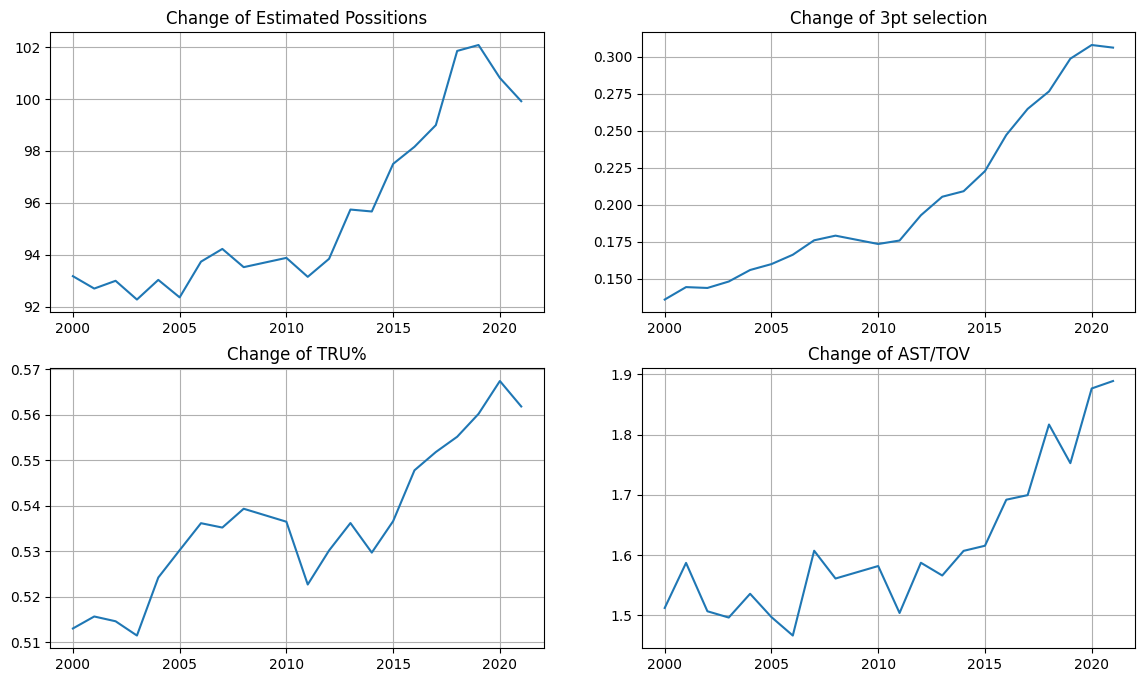

In [33]:
fig,ax = subplots(2,2,figsize=(14,8))



ax[0,0].plot(changed_per48_df["Year"],changed_per48_df["POSS_es"])
ax[0,0].title.set_text("Change of Estimated Possitions")
ax[0,1].plot(changed_per48_df["Year"],changed_per48_df["FG3M/FGM"])
ax[0,1].title.set_text("Change of 3pt selection")
ax[1,0].plot(changed_per48_df["Year"],changed_per48_df["TRU%"])
ax[1,0].title.set_text("Change of TRU%")
ax[1,1].plot(changed_per48_df["Year"],changed_per48_df["AST/TOV"])
ax[1,1].title.set_text("Change of AST/TOV")
for i in range(0,2):
  for j in range(0,2):
    ax[i,j].grid(True)
show()

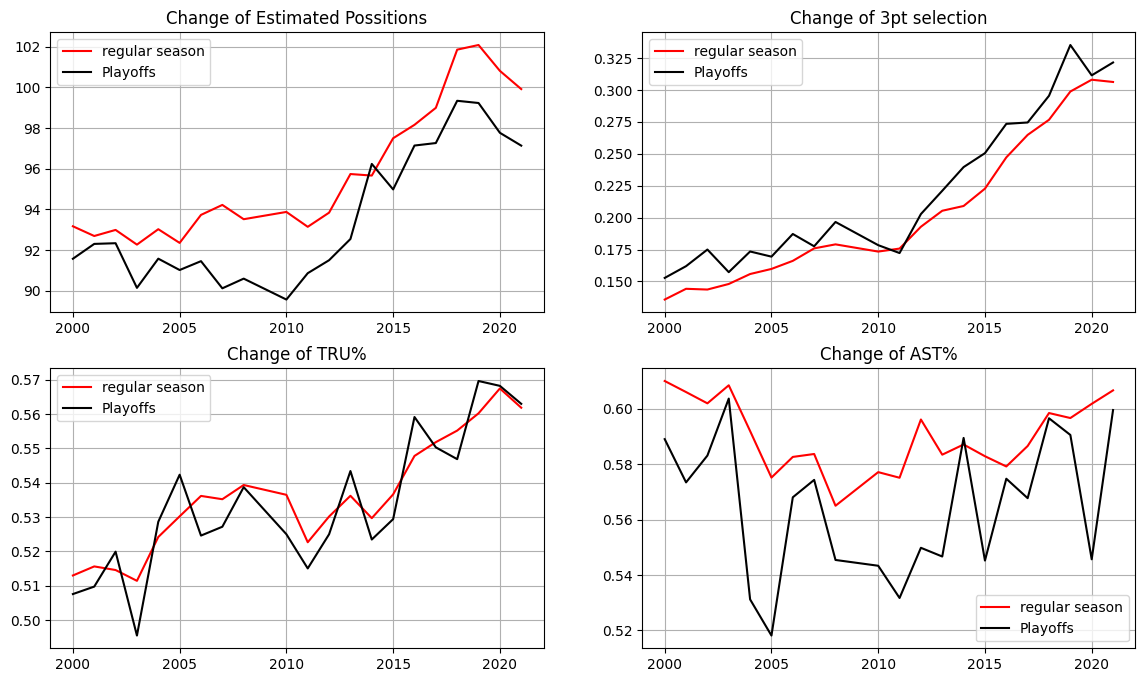

In [61]:
fig,ax = subplots(2,2,figsize=(14,8))

ax[0,0].plot(changed_per48_df["Year"],changed_per48_df["POSS_es"],label = "regular season",c = 'r')
ax[0,0].plot(play_per48["Year"],play_per48["POSS_es"],label="Playoffs",c = "k")
ax[0,0].title.set_text("Change of Estimated Possitions")
ax[0,1].plot(changed_per48_df["Year"],changed_per48_df["FG3M/FGM"],label = "regular season",c = 'r')
ax[0,1].plot(play_per48["Year"],play_per48["FG3M/FGM"],label="Playoffs",c = "k")
ax[0,1].title.set_text("Change of 3pt selection")
ax[1,0].plot(changed_per48_df["Year"],changed_per48_df["TRU%"],label = "regular season",c = 'r')
ax[1,0].plot(play_per48["Year"],play_per48["TRU%"],label="Playoffs",c = "k")
ax[1,0].title.set_text("Change of TRU%")
ax[1,1].plot(changed_per48_df["Year"],changed_per48_df["AST%"],label = "regular season",c = 'r')
ax[1,1].plot(play_per48["Year"],play_per48["AST%"],label="Playoffs",c = "k")
ax[1,1].title.set_text("Change of AST%")
for i in range(0,2):
  for j in range(0,2):
    ax[i,j].grid(True)
    ax[i,j].legend()

show()

In [19]:
fig = go.Figure()
for col in changed_per48_df.columns[1:]:
  fig.add_trace(go.Scatter(x = changed_per48_df["Year"],y = changed_per48_df[col],name=col))

fig.show ()
